<a href="https://colab.research.google.com/github/golesuman/66-daysofdatachallenge/blob/main/Day54/generatingFaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#data preparation
!wget https://www.dropbox.com/s/rbajpdlh7efkdo1/male_female_face_images.zip
!unzip male_female_face_images

Streaming output truncated to the last 5000 lines.
  inflating: males/30272.jpg         
  inflating: males/30273.jpg         
  inflating: males/30274.jpg         
  inflating: males/3028.jpg          
  inflating: males/30281.jpg         
  inflating: males/30286.jpg         
  inflating: males/30287.jpg         
  inflating: males/30288.jpg         
  inflating: males/3029.jpg          
  inflating: males/30293.jpg         
  inflating: males/30294.jpg         
  inflating: males/30295.jpg         
  inflating: males/3030.jpg          
  inflating: males/30300.jpg         
  inflating: males/30301.jpg         
  inflating: males/30302.jpg         
  inflating: males/30307.jpg         
  inflating: males/30308.jpg         
  inflating: males/30309.jpg         
  inflating: males/30314.jpg         
  inflating: males/30315.jpg         
  inflating: males/30316.jpg         
  inflating: males/30321.jpg         
  inflating: males/30322.jpg         
  inflating: males/30323.jpg         

In [4]:
!pip install -q --upgrade torch_snippets
from torch_snippets import *
import cv2
from PIL import Image

In [7]:
from glob import glob
face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
!mkdir cropped_faces
images=glob('/content/females/*.jpg')+glob('/content/males/*.jpg')
for i in range(len(images)):
  img=cv2.imread(images[i])
  gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  faces=face_cascade.detectMultiScale(gray,1.3,5)
  for (x,y,w,h) in faces:
    img2=img[y:(y+h),x:(x+w),:]
  cv2.imwrite('cropped_faces/'+str(i)+'.jpg',cv2.cvtColor(img2,cv2.COLOR_RGB2BGR))

mkdir: cannot create directory ‘cropped_faces’: File exists


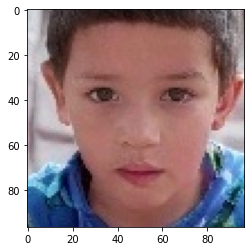

In [16]:
path='/content/cropped_faces'
train_images=[]
for img in os.listdir(path):
  img_array=cv2.imread(os.path.join(path,img))
  # colored_img=cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
  train_images.append(img_array)
plt.imshow(train_images[0])

In [40]:
transformer=transforms.Compose([
                                
                                transforms.ToTensor(),
                                transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                ])

# defining the Faces Dataset class
class Face_data(Dataset):
  def __init__(self,transform):
    super().__init__()
    self.x=train_images
    self.transform=transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self,ix):
    image=self.x[ix]
    image=self.transform(image)
    return image



In [43]:
ds=Face_data(transform=transformer)
dataloader=DataLoader(ds,batch_size=64,shuffle=True,num_workers=8)
img=next(iter(dataloader))
print(img[0])
print(img.shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([[[ 0.5744,  0.1111,  0.3024,  ...,  0.9068,  0.9393,  0.9509],
         [ 0.3783,  0.1857,  0.6259,  ...,  0.9244,  0.9451,  0.9432],
         [-0.0077,  0.7031,  0.3260,  ...,  0.9372,  0.9615,  0.9431],
         ...,
         [ 0.5992,  0.5973,  0.5731,  ...,  0.7725,  0.7814,  0.7857],
         [ 0.5853,  0.5964,  0.5949,  ...,  0.7725,  0.7812,  0.7858],
         [ 0.5942,  0.6220,  0.6163,  ...,  0.7842,  0.7930,  0.7888]],

        [[-0.1120, -0.4364, -0.0457,  ...,  0.9370,  0.9319,  0.9494],
         [-0.2214, -0.2889,  0.3342,  ...,  0.9463,  0.9437,  0.9432],
         [-0.4871,  0.3401,  0.1223,  ...,  0.9496,  0.9570,  0.9477],
         ...,
         [-0.8739, -0.8699, -0.8551,  ...,  0.8431,  0.8510,  0.8335],
         [-0.8689, -0.8545, -0.8197,  ...,  0.8431,  0.8510,  0.8322],
         [-0.8553, -0.8290, -0.8272,  ...,  0.8431,  0.8510,  0.8320]],

        [[ 0.0818, -0.2980,  0.0145,  ...,  0.9449,  0.9467,  0.9524],
         [-0.0756, -0.1890,  0.3629,  ...,  0

In [44]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [52]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.model=nn.Sequential(
        nn.Conv2d(3,64,4,2,1,bias=False),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(64,64*2,4,2,1,bias=False),
        nn.BatchNorm2d(64*2),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(64*2,64*4,4,2,1,bias=False),
        nn.BatchNorm2d(64*4),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(64*4,64*8,4,2,1,bias=False),
        nn.BatchNorm2d(64*8),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(64*8,1,4,1,0,bias=False),
        nn.Sigmoid()
    )
    self.apply(weights_init)

  def forward(self,x):
    return self.model(x)



In [53]:

discriminator=Discriminator().to(device)
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [55]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.model = nn.Sequential(
      nn.ConvTranspose2d(100,64*8,4,1,0,bias=False,),
      nn.BatchNorm2d(64*8),
      nn.ReLU(True),
      nn.ConvTranspose2d(64*8,64*4,4,2,1,bias=False),
      nn.BatchNorm2d(64*4),
      nn.ReLU(True),
      nn.ConvTranspose2d( 64*4,64*2,4,2,1,bias=False),
      nn.BatchNorm2d(64*2),
      nn.ReLU(True),
      nn.ConvTranspose2d( 64*2,64,4,2,1,bias=False),
      nn.BatchNorm2d(64),
      nn.ReLU(True),
      nn.ConvTranspose2d( 64,3,4,2,1,bias=False),
      nn.Tanh())
    self.apply(weights_init)


  def forward(self,x):
    return self.model(x)

  

In [56]:
generator=Generator().to(device)
print(generator)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [57]:
def discriminator_train_step(real_data, fake_data):
  d_optimizer.zero_grad()
  prediction_real = discriminator(real_data)
  error_real = loss(prediction_real.squeeze(), \
  torch.ones(len(real_data)).to(device))
  error_real.backward()
  prediction_fake = discriminator(fake_data)
  error_fake = loss(prediction_fake.squeeze(), \
  torch.zeros(len(fake_data)).to(device))
  error_fake.backward()
  d_optimizer.step()
  return error_real + error_fake
def generator_train_step(fake_data):
  g_optimizer.zero_grad()
  prediction = discriminator(fake_data)
  error = loss(prediction.squeeze(),torch.ones(len(real_data)).to(device))
  error.backward()
  g_optimizer.step()
  return error

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EPOCH: 1.000	d_loss: 0.633	g_loss: 10.015	(161.30s - 3871.19s remaining)
EPOCH: 2.000	d_loss: 0.573	g_loss: 5.993	(322.09s - 3704.03s remaining)
EPOCH: 3.000	d_loss: 0.515	g_loss: 4.972	(483.18s - 3543.35s remaining)
EPOCH: 4.000	d_loss: 0.518	g_loss: 4.400	(644.38s - 3383.00s remaining)
EPOCH: 5.000	d_loss: 0.528	g_loss: 4.068	(805.50s - 3221.99s remaining)
EPOCH: 6.000	d_loss: 0.589	g_loss: 3.858	(966.94s - 3061.98s remaining)
EPOCH: 7.000	d_loss: 0.583	g_loss: 3.532	(1128.89s - 2902.86s remaining)
EPOCH: 8.000	d_loss: 0.620	g_loss: 3.386	(1290.86s - 2743.07s remaining)
EPOCH: 9.000	d_loss: 0.607	g_loss: 3.363	(1452.68s - 2582.55s remaining)
EPOCH: 10.000	d_loss: 0.569	g_loss: 3.291	(1614.49s - 2421.73s remaining)
EPOCH: 11.000	d_loss: 0.560	g_loss: 3.285	(1776.11s - 2260.51s remaining)
EPOCH: 12.000	d_loss: 0.545	g_loss: 3.371	(1937.71s - 2099.19s remaining)
EPOCH: 13.000	d_loss: 0.505	g_loss: 3.485	(2099.31s - 1937.82s remaining)
EPOCH: 14.000	d_loss: 0.521	g_loss: 3.395	(2260.97s 

100%|██████████| 126/126 [00:00<00:00, 138.03it/s]



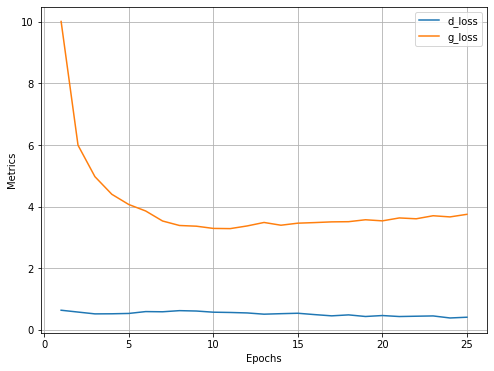

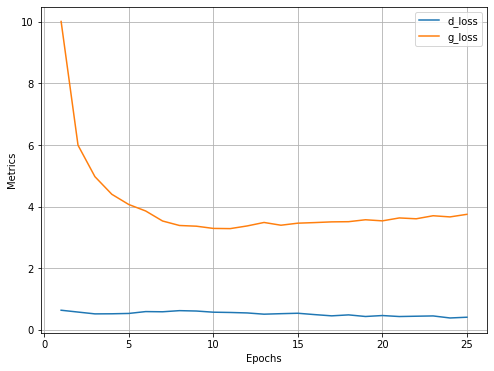

In [59]:
d_optimizer=optim.Adam(discriminator.parameters(),lr=0.0002,betas=(0.5,0.999))
g_optimizer=optim.Adam(generator.parameters(),lr=0.0002,betas=(0.5,0.999))
loss=nn.BCELoss()
log=Report(25)
for epoch in range(25):
  N=len(dataloader)
  for i, images in enumerate(dataloader):
    real_data=images.to(device)
    fake_data=generator(torch.randn(len(real_data),100,1,1).to(device)).to(device)
    fake_data.detach()
    d_loss=discriminator_train_step(real_data,fake_data)
    fake_data=generator(torch.randn(len(real_data),100,1,1).to(device)).to(device)
    g_loss=generator_train_step(fake_data)
    log.record(epoch+(1+i)/N,d_loss=d_loss.item(),g_loss=g_loss.item(),end='\r')
  log.report_avgs(epoch+1)
log.plot_epochs(['d_loss','g_loss'])




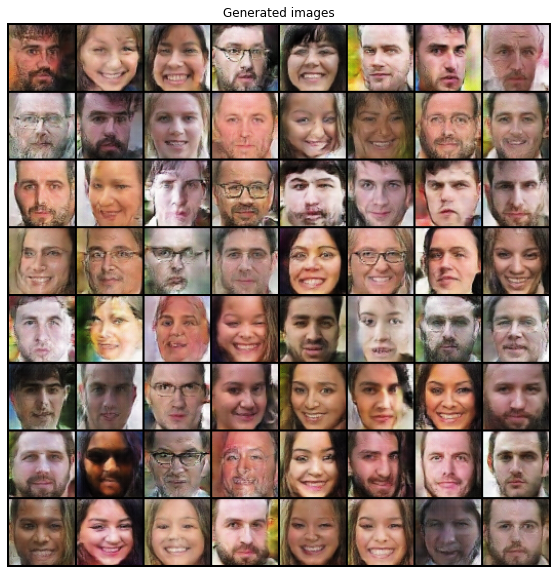

In [60]:
import torchvision.utils as vutils
generator.eval()
noise = torch.randn(64, 100, 1, 1, device=device)
sample_images = generator(noise).detach().cpu()
grid = vutils.make_grid(sample_images,nrow=8,normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=10, \
title='Generated images')